In [1]:
%matplotlib inline

import urllib, io, os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

from shapely.geometry import mapping, shape

import ee

In [2]:
ee.Initialize()

In [3]:
def maskQAv6(img):
    msk = img.select(['QC']).neq(0).neq(2).neq(4)
    return img.updateMask(msk).unmask(9999)

def filtermap_MODIS(collection, start, end, scheme):
    ## load lc collection
    lc_data = ee.ImageCollection(collection).filterDate(start, end)

    if collection == 'MODIS/006/MCD12Q1':

        lc_data_clean = lc_data.map(maskQAv6)

        std = lc_data_clean.select(scheme).reduce(ee.Reducer.stdDev())

        mask3 = std.eq(0)

        reference_target = ee.Image(lc_data_clean.first()).select(scheme)

        target_final = ee.Image(reference_target).updateMask(mask3).unmask(9999)

        ##reclassify no target to mask values
        target_final = target_final.where(target_final.eq(9999), 0)

    if scheme == 'LC_Prop1':
        target_final = target_final.remap([0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 21, 22, 31, 32, 41, 42, 43],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

    elif scheme == 'LC_Prop2':
        target_final = target_final.remap([0, 1, 2, 3, 9, 10, 20, 25, 30, 35, 36, 40],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

    return target_final.unmask(0)

def unmaskvalues(img):
    return img.unmask(0)


In [4]:
fold = '0'
tyear = 2001
partition = 'train'
##input data
#land cover maps
MCD12Q1v6 = 'MODIS/006/MCD12Q1'

# #scale
terra = ee.Image('users/acocac/latin_decrease_2004_01_01_to_2018_05_09')

##Get information about projection.
proj = terra.select(0).projection().crs().getInfo()
scale = terra.select(0).projection().nominalScale().getInfo()

##AOI
aoi = ee.FeatureCollection('users/acocacbasic/thesis/c5/fold' + fold + '_all_hpt')

##time period
tS = str(tyear) + '-01-01'
tE = str(tyear) + '-12-31'

#### LC map ####
finalmapv6_LCProp2_ = filtermap_MODIS(MCD12Q1v6, str(2001) + '-01-01', str(2003) + '-12-31', 'LC_Prop2');
finalmapv6_LCProp2_reclass = finalmapv6_LCProp2_.remap([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                                  [0, 1, 0, 2, 3, 4, 5, 0, 6, 0, 7, 8])

targetmap = finalmapv6_LCProp2_reclass

#### MODIS ####
MODIS_BANDS = ['sur_refl_b01', 'sur_refl_b02']
DEF_BANDS = ['red', 'NIR']

MODIS250m_coll = ee.ImageCollection('MODIS/006/MOD09Q1').filterDate(tS, tE).select(MODIS_BANDS, DEF_BANDS)

MODIS_BANDS =['sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
DEF_BANDS =['blue', 'green', 'SWIR1', 'SWIR2', 'SWIR3']

MODIS500m_coll = ee.ImageCollection('MODIS/006/MOD09A1').filterDate(tS, tE).select(MODIS_BANDS, DEF_BANDS)

MODIS_coll = ee.ImageCollection(MODIS250m_coll.combine(MODIS500m_coll))

MODIS_coll_filled = MODIS_coll.map(unmaskvalues)

#### SAMPLING ####
if partition == 'train':
    target = aoi.filter(ee.Filter.eq("split", 0))
elif partition == 'val':
    target = aoi.filter(ee.Filter.eq("split", 1))

#preprocess
targetmap = targetmap.addBands(ee.Image.pixelLonLat())
targetmap = targetmap.rename(["class", "longitude", "latitude" ]).cast({"class": "int8"})

In [5]:
evi_mean = MODIS_coll_filled.select('red').mean()
evi_median = MODIS_coll_filled.select('red').median()

In [6]:
# geometry = target.boundary().geometry()
# geometry = target.geometry().bounds()
geometry = target.first().geometry()

def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})


def retrieve(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)
                               
def show(image, path_out):
    plt.grid(False)
    
    if path_out:
        retrieve(image, path_out)
        plt.imshow(plt.imread(path_out))
    else:
        display(Image(url=get_path(image)))

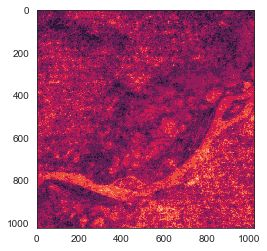

In [94]:
show(evi_mean.select('red'),'as.jpg')

In [11]:
hist = evi_mean.reduceRegion(ee.Reducer.histogram(150), geometry, scale, maxPixels=1e15).getInfo()

In [111]:
def values_band(lcclass):
    band_target = evi_mean.updateMask(lc.eq(lcclass).select('class'))
    bandvalues = band_target.reduceRegion(ee.Reducer.toList(), geometry, scale, maxPixels=1e15).getInfo()
    return lcclass, bandvalues['red']

In [124]:
truepred = np.empty((0, 2),dtype=int)

for i in range(1,9):
    x, z = values_band(i)
    x = np.tile(x,len(z))
    truepred = np.row_stack((truepred, np.column_stack((x, z))))

In [125]:
y_true = truepred[:, 0]
y_pred = truepred[:, 1]

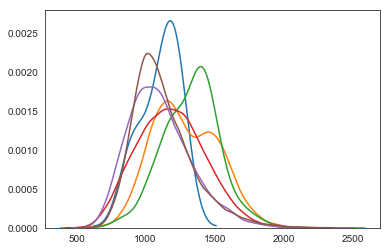

In [130]:
import matplotlib.pyplot as plt

iris = pd.DataFrame({'band': y_pred,'target':y_true})

unique_vals = iris['target'].unique()  # [0, 1, 2]

# Sort the dataframe by target
# Use a list comprehension to create list of sliced dataframes
targets = [iris.loc[iris['target'] == val] for val in unique_vals]

# Iterate through list and plot the sliced dataframe
for target in targets:
    sns.distplot(target[['band']], hist=False, rug=False, kde=True)

plt.show()

In [100]:
band_target = evi_mean.updateMask(lc.eq(0).select('class'))
lc_target = lc.updateMask(lc.eq(0))

bandvalues = band_target.reduceRegion(ee.Reducer.toList(), geometry, scale, maxPixels=1e15).getInfo()
lcvalues = lc_target.reduceRegion(ee.Reducer.toList(), geometry, scale, maxPixels=1e15).getInfo()

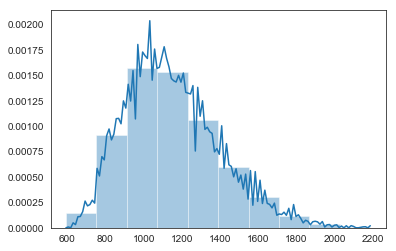

In [103]:
sns.set_style('white')
f = plt.figure()
sns.distplot(bandvalues['red'], bins=10, kde_kws={'bw': 0.02})
# plt.xlim(-1, 1)